In [86]:
# import necessary libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

# load the dataset
data = pd.read_csv(r'Sample - Superstore.csv', encoding="ISO-8859-1")

In [87]:
# Preprocess the data

# Drop rows with missing 'Customer ID'
data = data.dropna(subset=['Customer ID'])
# Convert 'Customer ID' to string type for consistency
data['Customer ID'] = data['Customer ID'].astype(str)
# Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])


In [88]:
# Create boxplots for 'Quantity' and 'Sales' using Plotly
fig = make_subplots(rows=1, cols=2)

# Add a vertical boxplot for 'Quantity' in the first column
fig.add_trace(go.Box(y=data['Quantity'], name='Quantity'), row=1, col=1)

# Add a vertical boxplot for 'UnitPrice' in the second column
fig.add_trace(go.Box(y=data['Sales'], name='Sales'), row=1, col=2)

# Update the layout
fig.update_layout(
    title='Boxplots for Quantity and Unit Price',
    height=400,
    width=800
)

# Show the plot
fig.show()

In [89]:
# Calculate original fences for Quantity
Q1_qty = data['Quantity'].quantile(0.25)
Q3_qty = data['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
lower_bound_qty = Q1_qty - 1.5 * IQR_qty
upper_bound_qty = Q3_qty + 1.5 * IQR_qty

# Calculate original fences for Sales
Q1_sales = data['Sales'].quantile(0.25)
Q3_sales = data['Sales'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
lower_bound_sales = Q1_sales - 1.5 * IQR_sales
upper_bound_sales = Q3_sales + 1.5 * IQR_sales

# Clean data by removing outliers according to original fences
data = data[
    (data['Quantity'] >= lower_bound_qty) & (data['Quantity'] <= upper_bound_qty) &
    (data['Sales'] >= lower_bound_sales) & (data['Sales'] <= upper_bound_sales)
]
# Print summary of potential outliers
print("Quantity Statistics:")
print(f"Values below: {Q1_qty - 1.5*IQR_qty}")
print(f"Values above: {Q3_qty + 1.5*IQR_qty}")


print("\nSales Statistics:")
print(f"Values below: {Q1_sales - 1.5*IQR_sales}")
print(f"Values above: {Q3_sales + 1.5*IQR_sales}")



Quantity Statistics:
Values below: -2.5
Values above: 9.5

Sales Statistics:
Values below: -271.71000000000004
Values above: 498.93


In [98]:
# Create boxplots for 'Quantity' and 'Sales' using Plotly
fig = make_subplots(rows=1, cols=2)

# Add a vertical boxplot for 'Quantity' in the first column
fig.add_trace(go.Box(y=data['Quantity'], name='Quantity',boxpoints=False), row=1, col=1)

# Add a vertical boxplot for 'UnitPrice' in the second column
fig.add_trace(go.Box(y=data['Sales'], name='Sales',boxpoints=False), row=1, col=2)

# Update the layout
fig.update_layout(
    title='Boxplots for Quantity and Unit Price (after outlier removal)',
    height=400,
    width=800
)

# Show the plot
fig.show()

In [91]:


# Calculating the total sum for each transaction
data['Total'] = data['Sales']*data['Quantity']

# Setting the snapshot date to the day after the last transaction
snapshot_date = data['Order Date'].max() + timedelta(days=1)


# Aggregating data per customer
data_process = data.groupby(['Customer ID']).agg(
    Recency=('Order Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Order ID', 'nunique'),   # or 'count' depending on dataset
    Monetary=('Total', 'sum')
).reset_index()


data_process


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,185,5,2935.992
1,AA-10375,20,9,1734.870
2,AA-10480,260,4,5493.936
3,AA-10645,56,6,3477.920
4,AB-10015,416,3,1984.480
...,...,...,...,...
785,XP-21865,44,11,8153.206
786,YC-21895,481,3,1567.328
787,YS-21880,135,7,7336.960
788,ZC-21910,55,13,9799.275


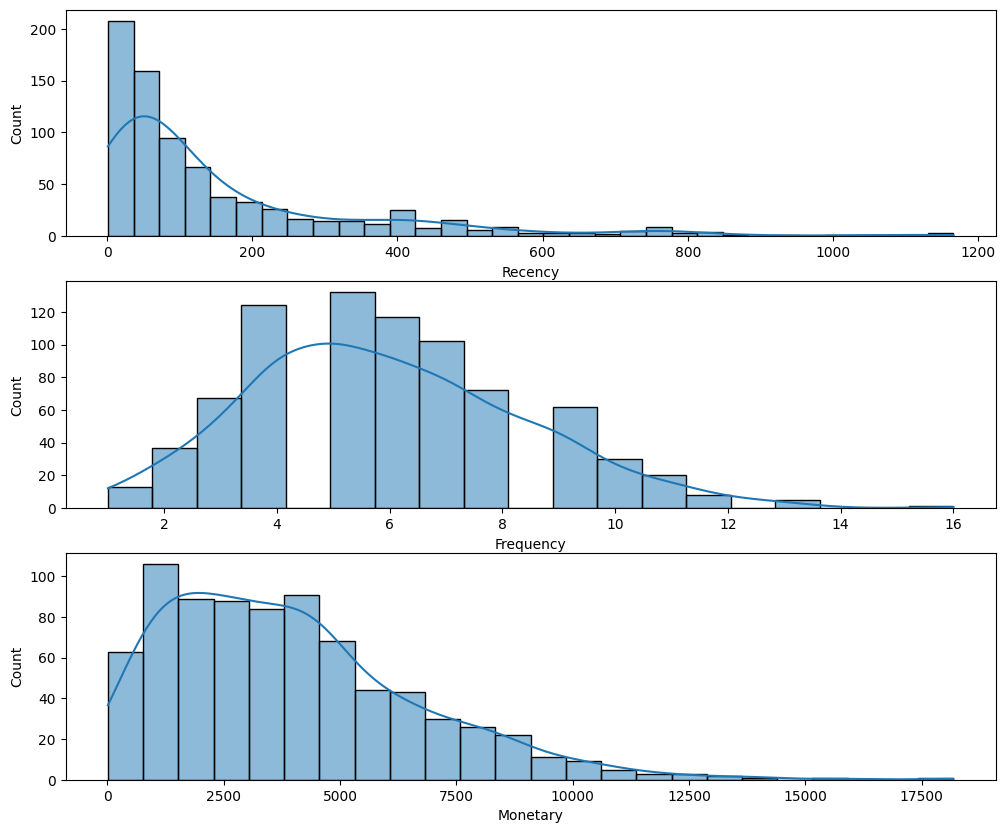

In [99]:
# Plot RFM distributions
plt.figure(figsize=(12,10))

# Plot distribution of R
plt.subplot(3, 1, 1)
sns.histplot(data_process['Recency'], kde=True)

# Plot distribution of F
plt.subplot(3, 1, 2)
sns.histplot(data_process['Frequency'], kde=True)

# Plot distribution of M
plt.subplot(3, 1, 3)
sns.histplot(data_process['Monetary'], kde=True)

# Show the plot
plt.show()

In [93]:
# Define the feature columns to be standardized.
feature_cols = ['Recency','Frequency','Monetary']

#Create a copy of the dataframe to hold the standardized values. This ensures the original data is not modified.
standardized_data = data_process.copy()

#Initialize the StandardScaler
scaler = StandardScaler()

#Compute the mean and standard deviation for scaling later, using only the feature columns specified earlier.
scaler.fit(data_process[feature_cols])

#Perform standardization by centering and scaling, based on the mean and standard deviation computed above.
standardized_features = scaler.transform(data_process[feature_cols])

#Update the original dataframe with the standardized values for the feature columns.
standardized_data[feature_cols] = standardized_features

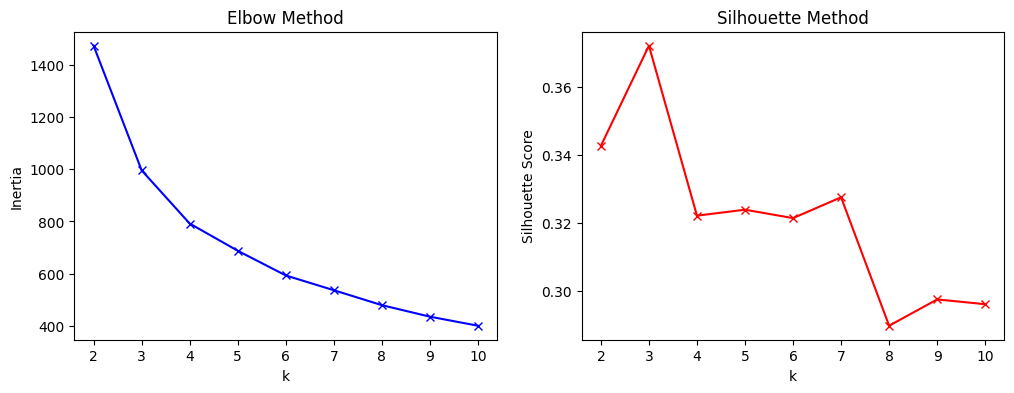

In [94]:
# Fit KMeans clustering for a range of k values and calculate inertia and silhouette scores


# Initialize lists to hold silhouette scores and inertias
sil_scores = []
inertias = []
K_range = range(2,11)

# Loop through the range of k values to fit KMeans and calculate inertia and silhouette scores
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(standardized_data[feature_cols])
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(standardized_data[feature_cols], labels))


# Plotting the results of the Elbow and Silhouette methods

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot
ax1.plot(K_range, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

# Silhouette plot
ax2.plot(K_range, sil_scores, 'rx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Method')

plt.show()


In [95]:
# Fit KMeans with the optimal number of clusters (k=3 in this case)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,  # This can be set to define the maximum number of iterations
    "random_state": 42  # Set the random state for reproducibility
}

kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(standardized_data[feature_cols])

# Add 1 to each label to change cluster numbering from 1
data_process['cluster'] = kmeans.labels_ + 1

# Reset the index of the DataFrame so 'Customer ID' becomes a regular column
data_process = data_process.reset_index()

# Group by cluster and calculate means and counts
centroid_df = data_process.groupby('cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'nunique'
}).reset_index()

# Rename the 'CustomerID' column to 'NumCustomers'
centroid_df = centroid_df.rename(columns={'Customer ID': 'No. Customers'})

# Sort by 'Frequency' in descending order
centroid_df = centroid_df.sort_values(by='Frequency', ascending=False)

# Add a new column 'MapCluster' based on frequency quartiles
centroid_df['MapCluster'] = pd.qcut(centroid_df['Frequency'], 3, labels=[1, 2, 3])

# Convert 'MapCluster' to integer type
centroid_df['MapCluster'] = centroid_df['MapCluster'].astype(int)

# Merge centroid_df with data_process to add 'MapCluster'
data_process = data_process.merge(centroid_df[['cluster', 'MapCluster']], on='cluster', how='left').reset_index(drop=True)

In [96]:
# Assigning cluster names to the centroids in the dataframe
cluster_names = ['Platinum', 'Gold', 'Silver']
# Adds a new column 'ClusterName' to centroid_df with the provided names
centroid_df['ClusterName'] = cluster_names
# Display the dataframe with the new 'ClusterName' column
centroid_df

,cluster,Recency,Frequency,Monetary,No. Customers,MapCluster,ClusterName
0,1,86.079832,8.584034,6830.897502,238,3,Platinum
1,2,95.211982,5.135945,2764.383879,434,2,Gold
2,3,555.957627,3.550847,2242.653758,118,1,Silver


In [97]:
# Creating a 3D scatter plot for RFM segmentation with color mapping for different RFM levels.
fig = px.scatter_3d(centroid_df, x='Recency', y='Frequency', z='Monetary',
              color='ClusterName', color_discrete_map={"Platinum": "blue", "Gold": "gold", "Silver": "darkgrey", "Bronze": "brown"},
              title="RFM Segmentation")
fig.show()  # Displays the plot in an interactive window.